In [ ]:
#!pip install librosa

TODO

ventanas a probar para el mfcc:
2048
1024
512 (lstm y gru, no rnn)

solapamiento del 50%

tunear los modelos

con el mejor modelo de los 3 hacer el experimento de concatenar el ruido gausiano con snr de 15 db al inicio y al final de la señal

probar las bilstm para el ruido y para cuando se tuneen los modelos

# CÓDIGO ORIGINAL

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
import torchaudio
import librosa

import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
from torchaudio.datasets import SPEECHCOMMANDS
import os

labels = ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house',
 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree',
 'two', 'up', 'visual', 'wow', 'yes', 'zero']

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or "Spectrogram (db)")
  axs.set_ylabel(ylabel)
  axs.set_xlabel("frame")
  im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
  fig.colorbar(im, ax=axs)
  plt.show(block=False)



class Create_DataSet(SPEECHCOMMANDS):
  def __init__(self, subset: str = None, ventanas: int = 2048):
    super().__init__("./", download=True)

    self.ventanas = ventanas
    self.subset = subset

    def load_list(filename):
        filepath = os.path.join(self._path, filename)
        with open(filepath) as fileobj:
            return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

    if subset == "validation":
        self._walker = load_list("validation_list.txt")
    elif subset == "testing":
        self._walker = load_list("testing_list.txt")
    elif subset == "training":
        excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
        excludes = set(excludes)
        self._walker = [w for w in self._walker if w not in excludes]


  def get_item_info(self, filepath: str, path: str):
      relpath = os.path.relpath(filepath, path)
      label, filename = os.path.split(relpath)
      speaker, _ = os.path.splitext(filename)
      speaker, _ = os.path.splitext(speaker)

      speaker_id, utterance_number = speaker.split("_nohash_")
      utterance_number = int(utterance_number)

      # Load audio
      waveform, sample_rate = torchaudio.load(filepath)

      largo = waveform.shape[1]
      if largo != 16000:
        pad = (16000 - largo-1, 1)
        waveform = F.pad(waveform, pad, value=0)


      # MFCC
      n_mfcc = 13
      n_fft = self.ventanas
      win_length = None
      hop_length = int(self.ventanas/2)
      n_mels = 13
      args={"n_fft": n_fft, "n_mels": n_mels, "hop_length": hop_length, "mel_scale": "htk"}

      mfcc_transform = T.MFCC(sample_rate=sample_rate, n_mfcc=n_mfcc, melkwargs=args)
      MFCC = mfcc_transform(waveform)


      # Delta
      delta_transform = T.ComputeDeltas()
      Delta = delta_transform(MFCC[0])


      # Delta Delta
      Delta_Delta = delta_transform(Delta)


      clase = torch.tensor(labels.index(label))

      return waveform, MFCC[0], Delta, Delta_Delta, clase





  def __getitem__(self, n: int):
    
    fileid = self._walker[n]
    info = self.get_item_info(fileid, self._path)
    #return torch.cat((info[1], info[2], info[3]), 1), info[4]
    return info[1].T, info[4]


  def plot_wf_and_features(self, n):
    
    fileid = self._walker[n]
    info = self.get_item_info(fileid, self._path)

    plt.plot(info[0].t().numpy())
    plt.title(f"Waveform subset {self.subset}[{n}]")
    plot_spectrogram(info[1], title = f"MFCC subset {self.subset}[{n}]")
    plot_spectrogram(info[2], title = f"Delta subset {self.subset}[{n}]")
    plot_spectrogram(info[3], title = f"Delta-Delta subset {self.subset}[{n}]")

  def get_waveform(self, n: int):
    fileid = self._walker[n]
    info = self.get_item_info(fileid, self._path)

    return info[0]

Crear los Datasets

In [4]:
# Create training, validation and testing split of the data.

train_dataset = Create_DataSet("training")
val_dataset = Create_DataSet("validation")
test_dataset = Create_DataSet("testing")

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

In [ ]:
train_dataset[0][0].shape

torch.Size([16, 13])

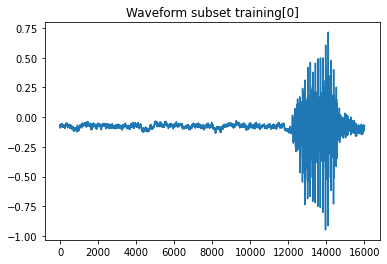

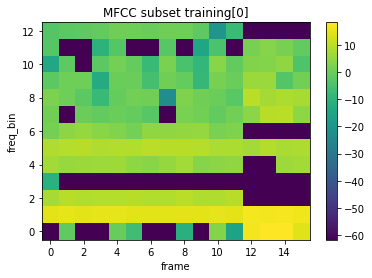

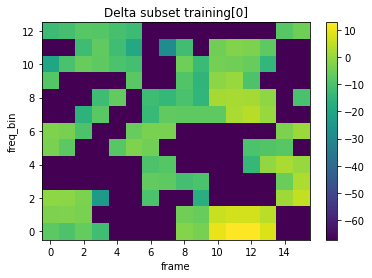

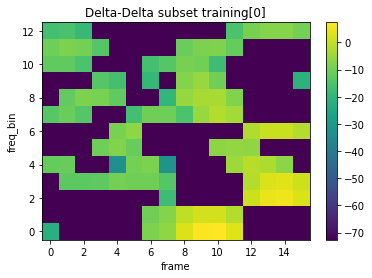

In [ ]:
train_dataset.plot_wf_and_features(0)

# Modelos

In [5]:
class RNNModel(nn.Module):
    def __init__(
        self,
        n_input_channels,
        hidd_size=128,
        num_layers=1,
    ):
        super().__init__()

        self.rnn_layer = nn.RNN(n_input_channels, hidd_size, batch_first=True, num_layers=num_layers)

        self.net = nn.Sequential(
            nn.Linear(hidd_size, 35),
        )

        self.flatten_layer = nn.Flatten()

    def forward(self, x):
        
        out, h = self.rnn_layer(x)
            
        out = h[-1]

        return self.net(out)

In [6]:
class LSTMModel(nn.Module):
    def __init__(
        self,
        n_input_channels,
        hidd_size=128,
        num_layers=1,
    ):
        super().__init__()

        self.rnn_layer = nn.LSTM(n_input_channels, hidd_size, batch_first=True, num_layers=num_layers)

        self.net = nn.Sequential(
            nn.Linear(hidd_size, 35),
        )

        self.flatten_layer = nn.Flatten()

    def forward(self, x):
        
        out, (h, c) = self.rnn_layer(x)
            
        out = h[-1]

        return self.net(out)

In [7]:
class GRUModel(nn.Module):
    def __init__(
        self,
        n_input_channels,
        hidd_size=128,
        num_layers=1,
    ):
        super().__init__()

        self.rnn_layer = nn.GRU(n_input_channels, hidd_size, batch_first=True, num_layers=num_layers)

        self.net = nn.Sequential(
            nn.Linear(hidd_size, 35),
        )

        self.flatten_layer = nn.Flatten()

    def forward(self, x):
        
        out, h = self.rnn_layer(x)
            
        out = h[-1]

        return self.net(out)

#Entrenamiento

## Funciones para entrenar

In [8]:
import time

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
import seaborn as sns

In [9]:
def show_curves(all_curves):

    final_curve_means = {k: np.mean([c[k] for c in all_curves], axis=0) for k in all_curves[0].keys()}
    final_curve_stds = {k: np.std([c[k] for c in all_curves], axis=0) for k in all_curves[0].keys()}

    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(final_curve_means["val_loss"])) + 1

    ax[0].plot(epochs, final_curve_means['val_loss'], label='validation')
    ax[0].plot(epochs, final_curve_means['train_loss'], label='training')
    ax[0].fill_between(epochs, y1=final_curve_means["val_loss"] - final_curve_stds["val_loss"], y2=final_curve_means["val_loss"] + final_curve_stds["val_loss"], alpha=.5)
    ax[0].fill_between(epochs, y1=final_curve_means["train_loss"] - final_curve_stds["train_loss"], y2=final_curve_means["train_loss"] + final_curve_stds["train_loss"], alpha=.5)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, final_curve_means['val_acc'], label='validation')
    ax[1].plot(epochs, final_curve_means['train_acc'], label='training')
    ax[1].fill_between(epochs, y1=final_curve_means["val_acc"] - final_curve_stds["val_acc"], y2=final_curve_means["val_acc"] + final_curve_stds["val_acc"], alpha=.5)
    ax[1].fill_between(epochs, y1=final_curve_means["train_acc"] - final_curve_stds["train_acc"], y2=final_curve_means["train_acc"] + final_curve_stds["train_acc"], alpha=.5)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.show()

def get_metrics_and_confusion_matrix(model, dataset):
    model.cpu()
    model.eval()
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=min(16, len(dataset)))
    y_true = []
    y_pred = []
    for x, y in dataloader:
        y_true.append(y)
        y_pred.append(model(x).argmax(dim=1))

    y_true = torch.cat(y_true)
    y_pred = torch.cat(y_pred)

    print(f"Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%")
    
    fig, ax = plt.subplots(figsize=(8, 7))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels, xticks_rotation="vertical", include_values=False, ax=ax)
    plt.show()

In [10]:
class EarlyStopping:
    def __init__(self, n_epochs_tolerance):
        self.n_epochs_tolerance = n_epochs_tolerance
        self.epochs_with_no_improvement = 0
        self.best_loss = np.inf

    def __call__(self, val_loss):
        # En cada llamada aumentamos el número de épocas en que no hemos mejorado
        self.epochs_with_no_improvement += 1

        if val_loss <= self.best_loss:
            # Si efectivamente mejoramos (menor loss de validación) reiniciamos el número de épocas sin mejora
            self.best_loss = val_loss
            self.epochs_with_no_improvement = 0

        # Retornamos True si debemos detenernos y False si aún no
        # Nos detenemos cuando el número de épocas sin mejora es mayor o igual que el número de épocas de tolerancia
        return self.epochs_with_no_improvement >= self.n_epochs_tolerance

In [11]:
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):
    # Predicción
    y_predicted = model(x_batch)

    # Cálculo de loss
    loss = criterion(y_predicted, y_batch)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss


def evaluate(val_loader, model, criterion, use_gpu):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0

    for x_val, y_val in val_loader:
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)
        
        loss = criterion(y_predicted, y_val)

        class_prediction = torch.argmax(y_predicted, axis=1).long()

        cumulative_predictions += (y_val == class_prediction).sum().item()
        cumulative_loss += loss.item() * y_val.shape[0]
        data_count += y_val.shape[0]

    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss / data_count

    return val_acc, val_loss


def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    early_stopping_tolerance=15,
    n_evaluations_per_epoch=6,
    use_gpu=False,
):
    if use_gpu:
        model.cuda()


    early_stopping = EarlyStopping(n_epochs_tolerance=early_stopping_tolerance)

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=use_gpu)

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)
    print(n_batches)

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        examples_count = 0

        # Entrenamiento del modelo
        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)

            cumulative_train_loss += loss.item() * x_batch.shape[0]
            examples_count += y_batch.shape[0]

            # Calculamos número de aciertos
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / examples_count
                train_acc = cumulative_train_corrects / examples_count

                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}, Train acc: {train_acc}")

            iteration += 1

        model.eval()
        with torch.no_grad():
            val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

        print(f"Val loss: {val_loss}, Val acc: {val_acc}")

        train_loss = cumulative_train_loss / examples_count
        train_acc = cumulative_train_corrects / examples_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)


        if early_stopping(val_loss):
            print("Early stopping.")
            break

    print()
    total_time = time.perf_counter() - t0
    print(f"Tiempo total de entrenamiento: {total_time:.4f} [s]")

    model.cpu()

    return curves, total_time

## Entrenamiento con ventanas de 2048

In [ ]:
# Create training, validation and testing split of the data.

train_dataset_2048 = Create_DataSet("training", 2048)
val_dataset_2048 = Create_DataSet("validation", 2048)
test_dataset_2048 = Create_DataSet("testing", 2048)

In [ ]:
lr = 1e-4 
batch_size = 16
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 50

all_curves = []
times = []

for train_run in range(n_trains):
    model_rnn_2048 = RNNModel(13)

    curves, total_time = train_model(
        model_rnn_2048,
        train_dataset_2048,
        val_dataset_2048,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

5303
Epoch 1/50
Iteration 883 - Batch 883/5303 - Train loss: 3.515746271987846, Train acc: 0.047652714932126694
Iteration 1766 - Batch 1766/5303 - Train loss: 3.479068767707363, Train acc: 0.055531975099037914
Iteration 2649 - Batch 2649/5303 - Train loss: 3.446143501299732, Train acc: 0.06181603773584906
Iteration 3532 - Batch 3532/5303 - Train loss: 3.4009398371445165, Train acc: 0.0700891593546561
Iteration 4415 - Batch 4415/5303 - Train loss: 3.3390549995760987, Train acc: 0.08113960597826086
Iteration 5298 - Batch 5298/5303 - Train loss: 3.281255556561178, Train acc: 0.09206925835063219
Val loss: 2.9140020628847827, Val acc: 0.16611561967738703
Epoch 2/50
Iteration 6186 - Batch 883/5303 - Train loss: 2.9042036749119133, Train acc: 0.15886595022624433
Iteration 7069 - Batch 1766/5303 - Train loss: 2.870207700340776, Train acc: 0.16988539898132426
Iteration 7952 - Batch 2649/5303 - Train loss: 2.8285407311961337, Train acc: 0.17886792452830189
Iteration 8835 - Batch 3532/5303 - Trai

6527
Epoch 1/25
Iteration 1087 - Batch 1087/6527 - Train loss: 3.472746910417781, Train acc: 0.06532805429864254
Iteration 2174 - Batch 2174/6527 - Train loss: 3.336853470418645, Train acc: 0.09446507515473032
Iteration 3261 - Batch 3261/6527 - Train loss: 3.22942144793283, Train acc: 0.11345092675564779
Iteration 4348 - Batch 4348/6527 - Train loss: 3.1531647036721937, Train acc: 0.12807541963669808
Iteration 5435 - Batch 5435/6527 - Train loss: 3.0925065228568887, Train acc: 0.13978038150223582
Iteration 6522 - Batch 6522/6527 - Train loss: 3.0428979350766503, Train acc: 0.1491409096805387
Val loss: 2.7138997015381205, Val acc: 0.2186153692014828
Epoch 2/25


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa1ebd5f050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa1ebd5f050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Iteration 7614 - Batch 1087/6527 - Train loss: 2.713028148364495, Train acc: 0.217618778280543
Iteration 8701 - Batch 2174/6527 - Train loss: 2.6929532559164637, Train acc: 0.22408488063660478
Iteration 9788 - Batch 3261/6527 - Train loss: 2.6700106654190563, Train acc: 0.23065132292600105
Iteration 10875 - Batch 4348/6527 - Train loss: 2.6446799556258958, Train acc: 0.23458973769389957
Iteration 11962 - Batch 5435/6527 - Train loss: 2.6219933057331355, Train acc: 0.24114167657214014
Iteration 13049 - Batch 6522/6527 - Train loss: 2.6022158869932386, Train acc: 0.2464415853960542
Val loss: 2.4335990821583073, Val acc: 0.2955615669772568
Epoch 3/25
Iteration 14141 - Batch 1087/6527 - Train loss: 2.4412348744842935, Train acc: 0.2895927601809955
Iteration 15228 - Batch 2174/6527 - Train loss: 2.4230762505805354, Train acc: 0.29541998231653405
Iteration 16315 - Batch 3261/6527 - Train loss: 2.4095225309316985, Train acc: 0.2995095033721643
Iteration 17402 - Batch 4348/6527 - Train loss: 2

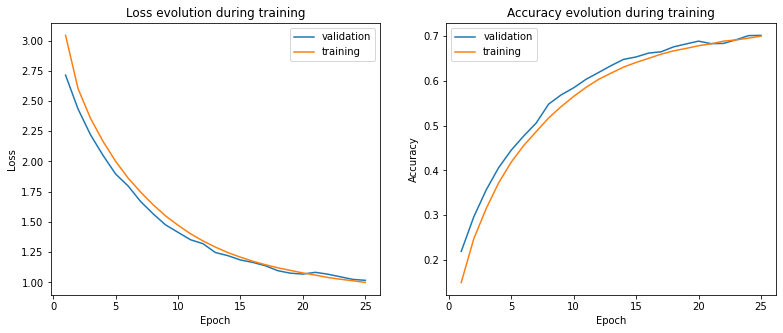

In [ ]:
lr = 1e-4 
batch_size = 13
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 25#40

all_curves = []
times = []

for train_run in range(n_trains):
    model_rnn_2048 = RNNModel(48)

    curves, total_time = train_model(
        model_rnn_2048,
        train_dataset_2048,
        val_dataset_2048,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

Accuracy: 66.61%


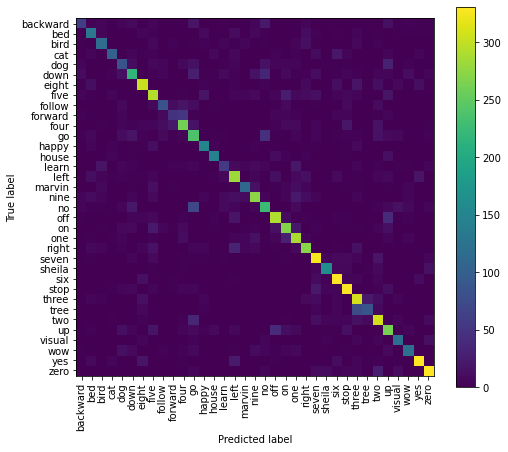

In [ ]:
get_metrics_and_confusion_matrix(model_rnn_2048, test_dataset_2048)

6527
Epoch 1/25
Iteration 1087 - Batch 1087/6527 - Train loss: 3.5177334334482167, Train acc: 0.04786481900452489
Iteration 2174 - Batch 2174/6527 - Train loss: 3.4661935191318904, Train acc: 0.05803713527851459
Iteration 3261 - Batch 3261/6527 - Train loss: 3.4128395990679263, Train acc: 0.0706503796632552
Iteration 4348 - Batch 4348/6527 - Train loss: 3.358734815360267, Train acc: 0.08258308718184551
Iteration 5435 - Batch 5435/6527 - Train loss: 3.302368275947304, Train acc: 0.09517744948208524
Iteration 6522 - Batch 6522/6527 - Train loss: 3.239356368665916, Train acc: 0.10886920836330617
Val loss: 2.815296127112759, Val acc: 0.21701232341448753
Epoch 2/25
Iteration 7614 - Batch 1087/6527 - Train loss: 2.781783139004427, Train acc: 0.21811368778280543
Iteration 8701 - Batch 2174/6527 - Train loss: 2.7238692301717298, Train acc: 0.2303448275862069
Iteration 9788 - Batch 3261/6527 - Train loss: 2.6819040293637992, Train acc: 0.2402961845021931
Iteration 10875 - Batch 4348/6527 - Trai

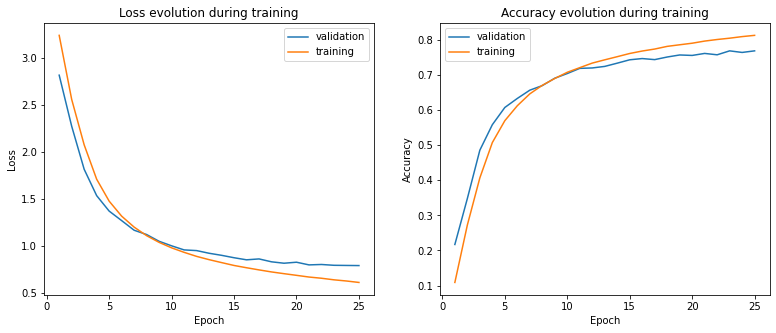

In [ ]:
lr = 1e-4 
batch_size = 13
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 25#40

all_curves = []
times = []

for train_run in range(n_trains):
    model_lstm_2048 = LSTMModel(48)

    curves, total_time = train_model(
        model_lstm_2048,
        train_dataset_2048,
        val_dataset_2048,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

Accuracy: 73.84%


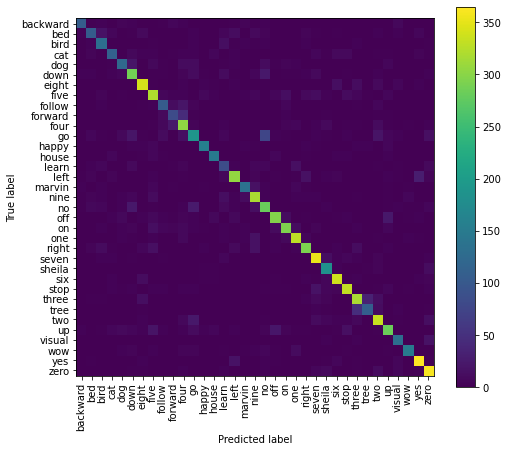

In [ ]:
get_metrics_and_confusion_matrix(model_lstm_2048, test_dataset_2048)

6527
Epoch 1/25
Iteration 1087 - Batch 1087/6527 - Train loss: 3.4967044149251545, Train acc: 0.05606617647058824
Iteration 2174 - Batch 2174/6527 - Train loss: 3.4519326568471973, Train acc: 0.06557029177718833
Iteration 3261 - Batch 3261/6527 - Train loss: 3.405709513194133, Train acc: 0.07444701221525256
Iteration 4348 - Batch 4348/6527 - Train loss: 3.35488267881236, Train acc: 0.0842457151953588
Iteration 5435 - Batch 5435/6527 - Train loss: 3.30706809095989, Train acc: 0.09326710816777042
Iteration 6522 - Batch 6522/6527 - Train loss: 3.2558815475258016, Train acc: 0.10319697166240167
Val loss: 2.8950238975276092, Val acc: 0.1829476004408376
Epoch 2/25
Iteration 7614 - Batch 1087/6527 - Train loss: 2.8813431433895054, Train acc: 0.1795814479638009
Iteration 8701 - Batch 2174/6527 - Train loss: 2.8454611458175485, Train acc: 0.18684350132625996
Iteration 9788 - Batch 3261/6527 - Train loss: 2.80849268577495, Train acc: 0.1971419138801113
Iteration 10875 - Batch 4348/6527 - Train l

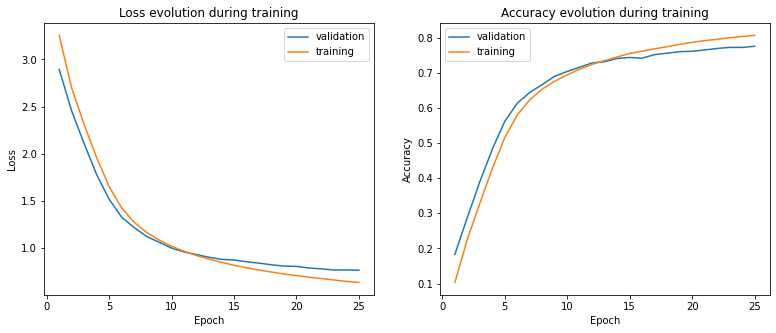

In [ ]:
lr = 1e-4 
batch_size = 13
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 25#40

all_curves = []
times = []

for train_run in range(n_trains):
    model_gru_2048 = GRUModel(48)

    curves, total_time = train_model(
        model_gru_2048,
        train_dataset_2048,
        val_dataset_2048,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

Accuracy: 74.57%


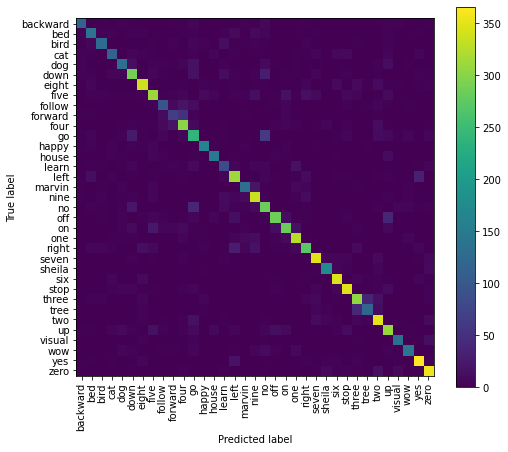

In [ ]:
get_metrics_and_confusion_matrix(model_gru_2048, test_dataset_2048)

## Entrenamiento con ventanas de 1024

In [ ]:
# Create training, validation and testing split of the data.

train_dataset_1024 = Create_DataSet("training", 1024)
val_dataset_1024 = Create_DataSet("validation", 1024)
test_dataset_1024 = Create_DataSet("testing", 1024)

6527
Epoch 1/25
Iteration 1087 - Batch 1087/6527 - Train loss: 3.48240451843423, Train acc: 0.05945984162895927
Iteration 2174 - Batch 2174/6527 - Train loss: 3.405126855894067, Train acc: 0.07540229885057471
Iteration 3261 - Batch 3261/6527 - Train loss: 3.311853053597568, Train acc: 0.09385464321086638
Iteration 4348 - Batch 4348/6527 - Train loss: 3.235606419187657, Train acc: 0.10881369722482621
Iteration 5435 - Batch 5435/6527 - Train loss: 3.17648841665456, Train acc: 0.12040810550744326
Iteration 6522 - Batch 6522/6527 - Train loss: 3.1262471492755055, Train acc: 0.13009587377209636
Val loss: 2.808967132246359, Val acc: 0.20018034265103696
Epoch 2/25
Iteration 7614 - Batch 1087/6527 - Train loss: 2.80197061138118, Train acc: 0.1978930995475113
Iteration 8701 - Batch 2174/6527 - Train loss: 2.7755412285903405, Train acc: 0.20367816091954022
Iteration 9788 - Batch 3261/6527 - Train loss: 2.7515492547442766, Train acc: 0.20895627977173042
Iteration 10875 - Batch 4348/6527 - Train l

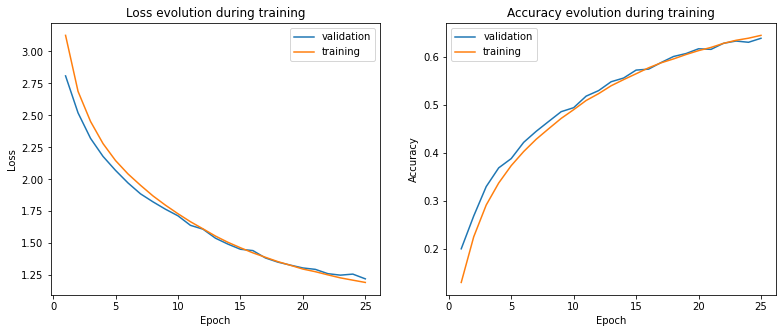

In [ ]:
lr = 1e-4 
batch_size = 13
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 25#40

all_curves = []
times = []

for train_run in range(n_trains):
    model_rnn_1024 = RNNModel(96)

    curves, total_time = train_model(
        model_rnn_1024,
        train_dataset_1024,
        val_dataset_1024,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

Accuracy: 60.53%


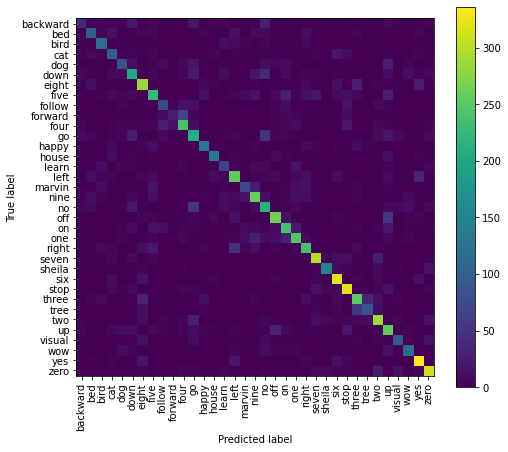

In [ ]:
get_metrics_and_confusion_matrix(model_rnn_1024, test_dataset_1024)

6527
Epoch 1/25
Iteration 1087 - Batch 1087/6527 - Train loss: 3.5225910428254044, Train acc: 0.044400452488687785
Iteration 2174 - Batch 2174/6527 - Train loss: 3.4846692870129115, Train acc: 0.05676392572944297
Iteration 3261 - Batch 3261/6527 - Train loss: 3.4526140841876414, Train acc: 0.06421261142291185
Iteration 4348 - Batch 4348/6527 - Train loss: 3.419010862039955, Train acc: 0.0705732529140209
Iteration 5435 - Batch 5435/6527 - Train loss: 3.3867840985764115, Train acc: 0.07649855663100696
Iteration 6522 - Batch 6522/6527 - Train loss: 3.351156623162833, Train acc: 0.08344438024033302
Val loss: 3.104917468987394, Val acc: 0.1377617473199078
Epoch 2/25
Iteration 7614 - Batch 1087/6527 - Train loss: 3.064238968798343, Train acc: 0.14656391402714933
Iteration 8701 - Batch 2174/6527 - Train loss: 3.0141655291634044, Train acc: 0.1594341290893015
Iteration 9788 - Batch 3261/6527 - Train loss: 2.975431365151116, Train acc: 0.1683724001320568
Iteration 10875 - Batch 4348/6527 - Trai

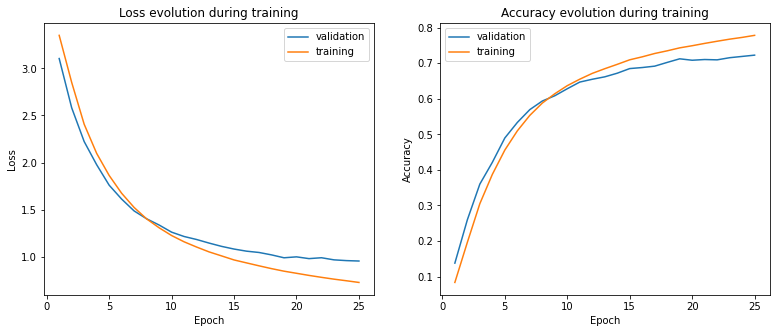

In [ ]:
lr = 1e-4 
batch_size = 13
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 25#40

all_curves = []
times = []

for train_run in range(n_trains):
    model_lstm_1024 = LSTMModel(96)

    curves, total_time = train_model(
        model_lstm_1024,
        train_dataset_1024,
        val_dataset_1024,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

Accuracy: 68.17%


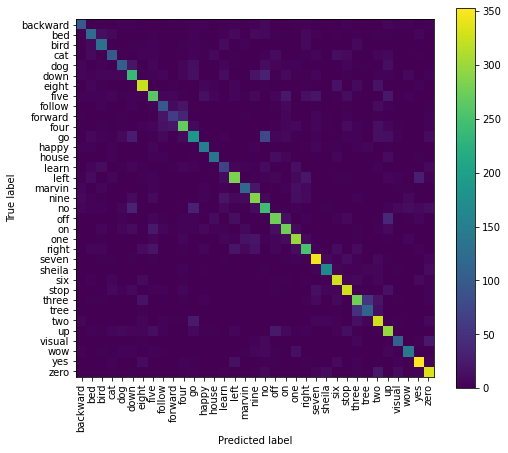

In [ ]:
get_metrics_and_confusion_matrix(model_lstm_1024, test_dataset_1024)

6527
Epoch 1/25
Iteration 1087 - Batch 1087/6527 - Train loss: 3.511561351006522, Train acc: 0.04850113122171946
Iteration 2174 - Batch 2174/6527 - Train loss: 3.470858000612807, Train acc: 0.057435897435897436
Iteration 3261 - Batch 3261/6527 - Train loss: 3.435217175799451, Train acc: 0.06711314436636324
Iteration 4348 - Batch 4348/6527 - Train loss: 3.3976243438597904, Train acc: 0.07598563772396838
Iteration 5435 - Batch 5435/6527 - Train loss: 3.362443016678906, Train acc: 0.08360219618497765
Iteration 6522 - Batch 6522/6527 - Train loss: 3.3214242999290153, Train acc: 0.09337374261488933
Val loss: 3.0345746726051455, Val acc: 0.16080553050796514
Epoch 2/25
Iteration 7614 - Batch 1087/6527 - Train loss: 3.006343071732451, Train acc: 0.16636029411764705
Iteration 8701 - Batch 2174/6527 - Train loss: 2.965445490650747, Train acc: 0.1740760389036251
Iteration 9788 - Batch 3261/6527 - Train loss: 2.92795780368702, Train acc: 0.18346460406546244
Iteration 10875 - Batch 4348/6527 - Trai

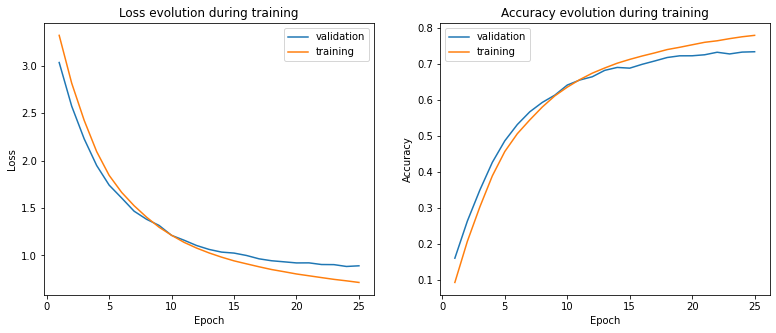

In [ ]:
lr = 1e-4 
batch_size = 13
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 25#40

all_curves = []
times = []

for train_run in range(n_trains):
    model_gru_1024 = GRUModel(96)

    curves, total_time = train_model(
        model_gru_1024,
        train_dataset_1024,
        val_dataset_1024,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

Accuracy: 69.84%


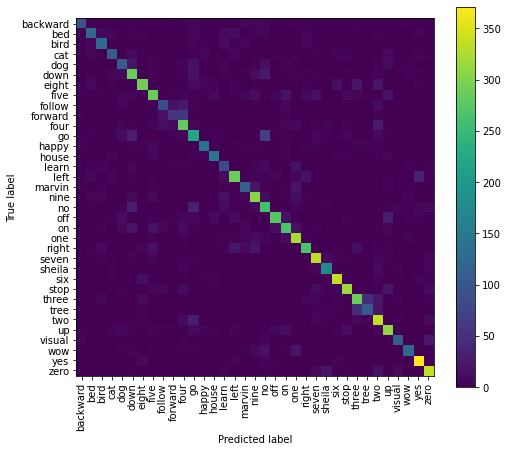

In [ ]:
get_metrics_and_confusion_matrix(model_gru_1024, test_dataset_1024)

## Entrenamiento con ventanas de 512

In [ ]:
# Create training, validation and testing split of the data.

train_dataset_512 = Create_DataSet("training", 512)
val_dataset_512 = Create_DataSet("validation", 512)
test_dataset_512 = Create_DataSet("testing", 512)

6527
Epoch 1/25
Iteration 1087 - Batch 1087/6527 - Train loss: 3.526146583697375, Train acc: 0.05210690045248869
Iteration 2174 - Batch 2174/6527 - Train loss: 3.46888945327408, Train acc: 0.06426171529619805
Iteration 3261 - Batch 3261/6527 - Train loss: 3.425273208439825, Train acc: 0.073810309861812
Iteration 4348 - Batch 4348/6527 - Train loss: 3.370004138828119, Train acc: 0.08500627907388082
Iteration 5435 - Batch 5435/6527 - Train loss: 3.31105274444472, Train acc: 0.0953755589517179
Iteration 6522 - Batch 6522/6527 - Train loss: 3.260351702385879, Train acc: 0.10448236417882287
Val loss: 2.9550010539548763, Val acc: 0.15489429916841999
Epoch 2/25
Iteration 7614 - Batch 1087/6527 - Train loss: 2.930010203491239, Train acc: 0.16197680995475114
Iteration 8701 - Batch 2174/6527 - Train loss: 2.9153927576130836, Train acc: 0.16696728558797524
Iteration 9788 - Batch 3261/6527 - Train loss: 2.9006677471297713, Train acc: 0.16907984719143518
Iteration 10875 - Batch 4348/6527 - Train lo

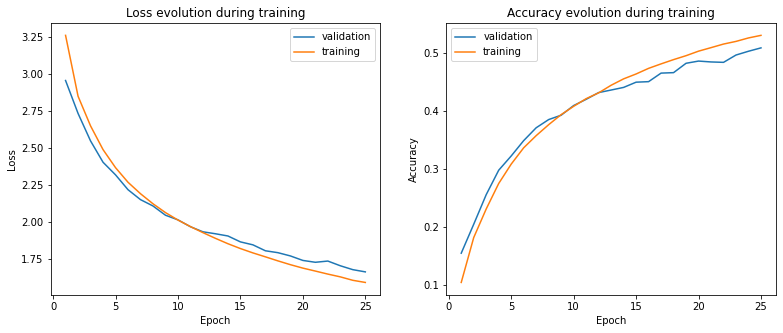

In [ ]:
lr = 1e-4 
batch_size = 13
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 25#40

all_curves = []
times = []

for train_run in range(n_trains):
    model_rnn_512 = RNNModel(189)

    curves, total_time = train_model(
        model_rnn_512,
        train_dataset_512,
        val_dataset_512,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

Accuracy: 48.08%


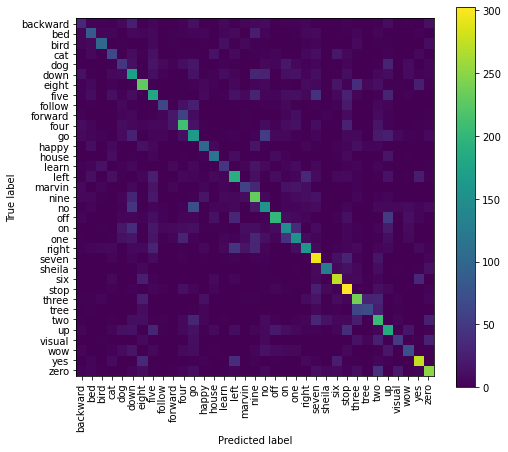

In [ ]:
get_metrics_and_confusion_matrix(model_rnn_512, test_dataset_512)

6527
Epoch 1/25
Iteration 1087 - Batch 1087/6527 - Train loss: 3.5234169782522846, Train acc: 0.047016402714932126
Iteration 2174 - Batch 2174/6527 - Train loss: 3.494241130653469, Train acc: 0.053934571175950484
Iteration 3261 - Batch 3261/6527 - Train loss: 3.470207901764033, Train acc: 0.059519879262368534
Iteration 4348 - Batch 4348/6527 - Train loss: 3.4473977179931867, Train acc: 0.0657976192581849
Iteration 5435 - Batch 5435/6527 - Train loss: 3.423550834938215, Train acc: 0.0706401766004415
Iteration 6522 - Batch 6522/6527 - Train loss: 3.3994193547857186, Train acc: 0.07576740291748724
Val loss: 3.2239508192903017, Val acc: 0.11882576896102595
Epoch 2/25
Iteration 7614 - Batch 1087/6527 - Train loss: 3.1892784566563717, Train acc: 0.1201923076923077
Iteration 8701 - Batch 2174/6527 - Train loss: 3.165857630214472, Train acc: 0.1258709106984969
Iteration 9788 - Batch 3261/6527 - Train loss: 3.136290938703653, Train acc: 0.13304721030042918
Iteration 10875 - Batch 4348/6527 - Tr

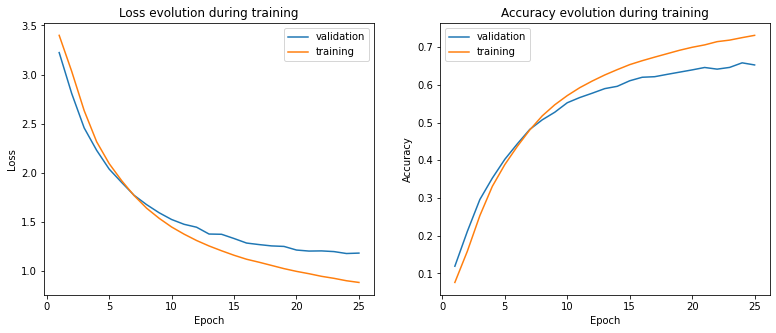

In [ ]:
lr = 1e-4 
batch_size = 13
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 25#40

all_curves = []
times = []

for train_run in range(n_trains):
    model_lstm_512 = LSTMModel(189)

    curves, total_time = train_model(
        model_lstm_512,
        train_dataset_512,
        val_dataset_512,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

Accuracy: 62.16%


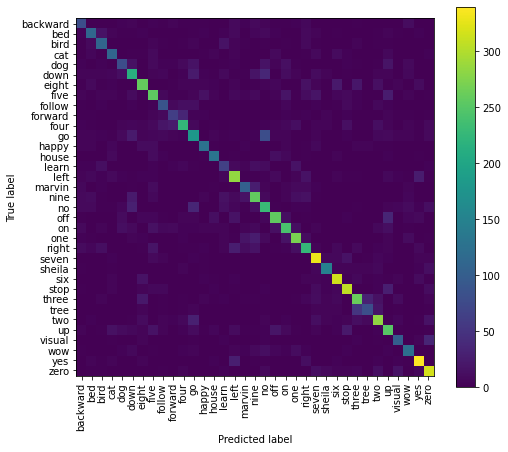

In [ ]:
get_metrics_and_confusion_matrix(model_lstm_512, test_dataset_512)

6527
Epoch 1/25
Iteration 1087 - Batch 1087/6527 - Train loss: 3.514368261046269, Train acc: 0.048430429864253395
Iteration 2174 - Batch 2174/6527 - Train loss: 3.4808569152875877, Train acc: 0.05641025641025641
Iteration 3261 - Batch 3261/6527 - Train loss: 3.4539697233114706, Train acc: 0.06305711455926048
Iteration 4348 - Batch 4348/6527 - Train loss: 3.427400981072421, Train acc: 0.06882218724021437
Iteration 5435 - Batch 5435/6527 - Train loss: 3.400818722532285, Train acc: 0.07447500990547348
Iteration 6522 - Batch 6522/6527 - Train loss: 3.3738652469737938, Train acc: 0.08064953596150898
Val loss: 3.18851864620985, Val acc: 0.11892595932271316
Epoch 2/25
Iteration 7614 - Batch 1087/6527 - Train loss: 3.1517898771254456, Train acc: 0.13588800904977374
Iteration 8701 - Batch 2174/6527 - Train loss: 3.125266343807352, Train acc: 0.14114942528735633
Iteration 9788 - Batch 3261/6527 - Train loss: 3.0911607669950776, Train acc: 0.14974296090175918
Iteration 10875 - Batch 4348/6527 - T

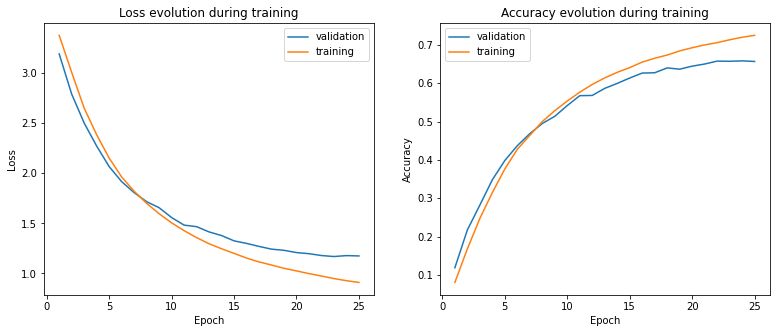

In [ ]:
lr = 1e-4 
batch_size = 13
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 25#40

all_curves = []
times = []

for train_run in range(n_trains):
    model_gru_512 = GRUModel(189)

    curves, total_time = train_model(
        model_gru_512,
        train_dataset_512,
        val_dataset_512,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

Accuracy: 62.75%


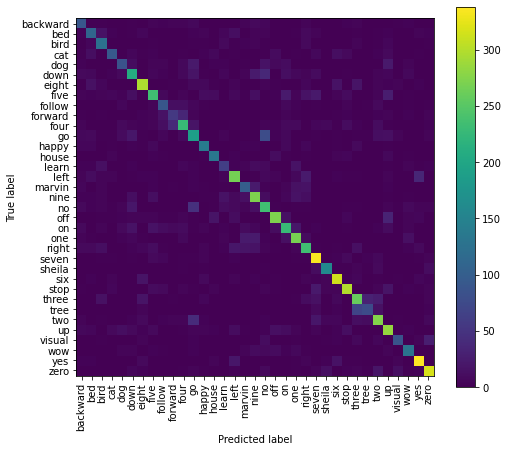

In [ ]:
get_metrics_and_confusion_matrix(model_gru_512, test_dataset_512)

# Audios con Ruido

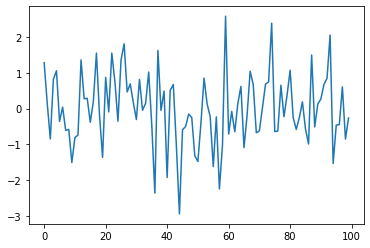

In [ ]:
noise = np.random.normal(0,1,100)
plt.plot(noise)

SMR in dB =  22.992439699783176
Average Noise power in dB =  7.992439699783176


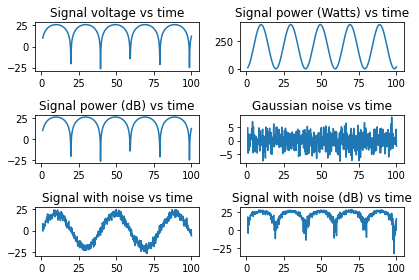

In [ ]:
target_snr_db = 15 # Desired target SNR in dB

# sine waveform generation with time vector
t = np.linspace(1, 100, 750)
x_volts = 20*np.sin(t/(2*np.pi))
x_watts = x_volts ** 2
x_db = 10 * np.log10(x_watts)

# Calculate signal power and convert to dB
sig_avg_watts = np.mean(x_watts)
sig_avg_db = 10 * np.log10(sig_avg_watts)
print("SMR in dB = ", sig_avg_db)

# Calculate noise and convert it to watts
noise_avg_db = sig_avg_db - target_snr_db
print("Average Noise power in dB = ", noise_avg_db)
noise_avg_watts = 10 ** (noise_avg_db / 10)
# Generate samples of white noise
mean_noise = 0
noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(x_watts))

# Add noise to original sine waveform signal
y_volts = x_volts + noise_volts

# Plots in dB
y_watts = y_volts ** 2
y_db = 10 * np.log10(y_watts)

# Plots
figure, axis = plt.subplots(3, 2)
axis[0,0].plot(t, x_db)
axis[0,0].set_title("Signal voltage vs time")
axis[0,1].plot(t, x_watts)
axis[0,1].set_title("Signal power (Watts) vs time")
axis[1,0].plot(t, x_db)
axis[1,0].set_title("Signal power (dB) vs time")
axis[1,1].plot(t, noise_volts)
axis[1,1].set_title("Gaussian noise vs time")
axis[2,0].plot(t, y_volts)
axis[2,0].set_title("Signal with noise vs time")
axis[2,1].plot(t, y_db)
axis[2,1].set_title("Signal with noise (dB) vs time")
plt.tight_layout()
plt.show()

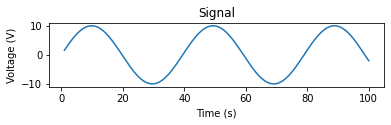

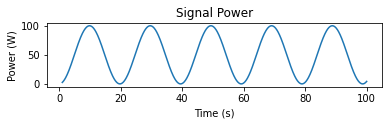

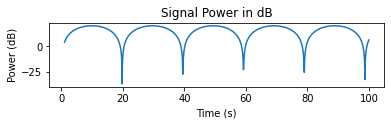

In [ ]:
# Signal Generation
# matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(1, 100, 1000)
x_volts = 10*np.sin(t/(2*np.pi))
# plt.subplot(3,1,1)
# plt.plot(t, x_volts)
# plt.title('Signal')
# plt.ylabel('Voltage (V)')
# plt.xlabel('Time (s)')
# plt.show()

x_watts = x_volts ** 2
# plt.subplot(3,1,2)
# plt.plot(t, x_watts)
# plt.title('Signal Power')
# plt.ylabel('Power (W)')
# plt.xlabel('Time (s)')
# plt.show()

x_db = 10 * np.log10(x_watts)
# plt.subplot(3,1,3)
# plt.plot(t, x_db)
# plt.title('Signal Power in dB')
# plt.ylabel('Power (dB)')
# plt.xlabel('Time (s)')
# plt.show()

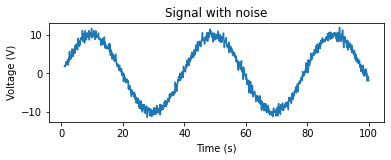

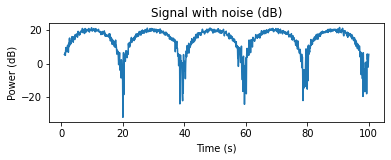

In [ ]:
# Adding noise using target SNR

# Set a target SNR
target_snr_db = 20
# Calculate signal power and convert to dB 
sig_avg_watts = np.mean(x_watts)
sig_avg_db = 10 * np.log10(sig_avg_watts)
# Calculate noise according to [2] then convert to watts
noise_avg_db = sig_avg_db - target_snr_db
noise_avg_watts = 10 ** (noise_avg_db / 10)
# Generate an sample of white noise
mean_noise = 0
noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(x_watts))
# Noise up the original signal
y_volts = x_volts + noise_volts

"""
# Plot signal with noise
plt.subplot(2,1,1)
plt.plot(t, y_volts)
plt.title('Signal with noise')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (s)')
plt.show()
# Plot in dB
y_watts = y_volts ** 2
y_db = 10 * np.log10(y_watts)
plt.subplot(2,1,2)
plt.plot(t, 10* np.log10(y_volts**2))
plt.title('Signal with noise (dB)')
plt.ylabel('Power (dB)')
plt.xlabel('Time (s)')
plt.show()
"""

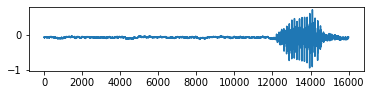

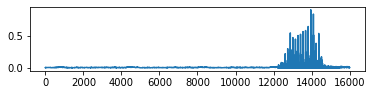

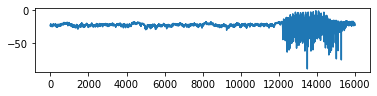

In [ ]:
signal = train_dataset.get_waveform(0).t().numpy()
signal_watts = signal ** 2
signal_db = 10 * np.log10(signal_watts)

plt.subplot(3,1,1)
plt.plot(signal)
plt.show()
plt.subplot(3,1,2)
plt.plot(signal_watts)
plt.show()
plt.subplot(3,1,3)
plt.plot(signal_db)
plt.show()

In [ ]:
# Adding noise using target SNR

# Set a target SNR
target_snr_db = 15
# Calculate signal power and convert to dB 
sig_avg_watts = np.mean(signal_watts)
sig_avg_db = 10 * np.log10(sig_avg_watts)
# Calculate noise according to [2] then convert to watts
noise_avg_db = sig_avg_db - target_snr_db
noise_avg_watts = 10 ** (noise_avg_db / 10)
# Generate an sample of white noise
mean_noise = 0
noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(signal_watts))
# Noise up the original signal
y_volts = signal + noise_volts


# Plot signal with noise
plt.subplot(2,1,1)
plt.plot(y_volts)
plt.title('Signal with noise')
plt.show()
# Plot in dB
y_watts = y_volts ** 2
y_db = 10 * np.log10(y_watts)
plt.subplot(2,1,2)
plt.plot(t, 10* np.log10(y_volts**2))
plt.title('Signal with noise (dB)')
plt.show()


In [ ]:
import math

from IPython.display import Audio
import matplotlib.pyplot as plt

from torchaudio.utils import download_asset

SAMPLE_WAV = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.wav")
SAMPLE_RIR = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo-8000hz.wav")
SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")
SAMPLE_NOISE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo-8000hz.wav")

  0%|          | 0.00/427k [00:00<?, ?B/s]

  0%|          | 0.00/31.3k [00:00<?, ?B/s]

  0%|          | 0.00/53.2k [00:00<?, ?B/s]

  0%|          | 0.00/78.2k [00:00<?, ?B/s]

In [ ]:
#speech, _ = torchaudio.load(SAMPLE_SPEECH)
#noise, _ = torchaudio.load(SAMPLE_NOISE)
#noise = noise[:, : speech.shape[1]]


signal = train_dataset.get_waveform(0)
noise = torch.randn(signal.shape)

speech_rms = signal.norm(p=2)
noise_rms = noise.norm(p=2)

snr_dbs = [20, 10, 3]
noisy_speeches = []
for snr_db in snr_dbs:
    snr = 10 ** (snr_db / 20)
    scale = snr * noise_rms / speech_rms
    noisy_speeches.append((scale * signal + noise) / 2)

In [ ]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

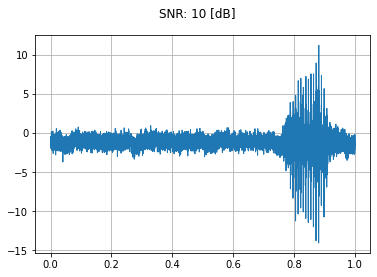

In [ ]:
snr_db, noisy_speech = snr_dbs[1], noisy_speeches[1]
plot_waveform(noisy_speech, 16000, title=f"SNR: {snr_db} [dB]")

#código para hacer señales con ruido

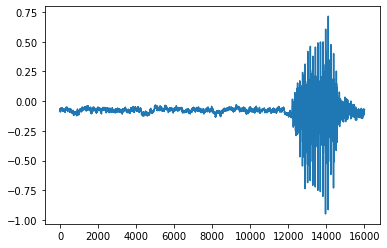

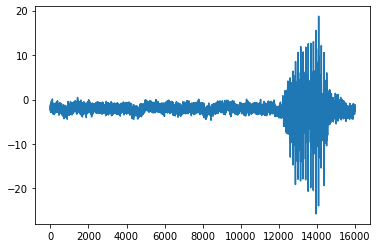

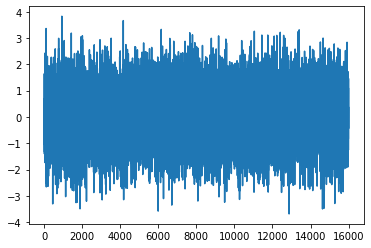

In [ ]:
signal = train_dataset.get_waveform(0)
noise = torch.randn(signal.shape)

speech_rms = signal.norm(p=2)
noise_rms = noise.norm(p=2)

snr_db = 15
noisy_speeches = []

snr = 10 ** (snr_db / 20)
scale = snr * noise_rms / speech_rms
# noisy_speeches.append((scale * signal + noise) / 2)
noisy = (scale * signal + noise) / 2

plt.plot(signal.t().numpy())
plt.show()
plt.plot(noisy.t().numpy())
plt.show()
plt.plot(noise.t().numpy())
plt.show()

In [12]:
from torchaudio.datasets import SPEECHCOMMANDS
import os

labels = ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house',
 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree',
 'two', 'up', 'visual', 'wow', 'yes', 'zero']

def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or "Spectrogram (db)")
  axs.set_ylabel(ylabel)
  axs.set_xlabel("frame")
  im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
  fig.colorbar(im, ax=axs)
  plt.show(block=False)



class Create_DataSet_Noisy(SPEECHCOMMANDS):
  def __init__(self, subset: str = None, ventanas: int = 2048):
    super().__init__("./", download=True)

    self.ventanas = ventanas
    self.subset = subset

    def load_list(filename):
        filepath = os.path.join(self._path, filename)
        with open(filepath) as fileobj:
            return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

    if subset == "validation":
        self._walker = load_list("validation_list.txt")
    elif subset == "testing":
        self._walker = load_list("testing_list.txt")
    elif subset == "training":
        excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
        excludes = set(excludes)
        self._walker = [w for w in self._walker if w not in excludes]


  def get_item_info(self, filepath: str, path: str):
      relpath = os.path.relpath(filepath, path)
      label, filename = os.path.split(relpath)
      speaker, _ = os.path.splitext(filename)
      speaker, _ = os.path.splitext(speaker)

      speaker_id, utterance_number = speaker.split("_nohash_")
      utterance_number = int(utterance_number)

      # Load audio
      waveform, sample_rate = torchaudio.load(filepath)

      largo = waveform.shape[1]
      if largo != 16000:
        pad = (16000 - largo-1, 1)
        waveform = F.pad(waveform, pad, value=0)


      # Add noise
      noise = torch.randn(waveform.shape)

      waveform_rms = waveform.norm(p=2)
      noise_rms = noise.norm(p=2)

      snr_db = 15 #dB del SNR

      snr = 10 ** (snr_db / 20)
      scale = snr * noise_rms / waveform_rms
      
      waveform = (scale * waveform + noise) / 2


      # MFCC
      n_mfcc = 13
      n_fft = self.ventanas
      win_length = None
      hop_length = int(self.ventanas/2)
      n_mels = 13
      args={"n_fft": n_fft, "n_mels": n_mels, "hop_length": hop_length, "mel_scale": "htk"}

      mfcc_transform = T.MFCC(sample_rate=sample_rate, n_mfcc=n_mfcc, melkwargs=args)
      MFCC = mfcc_transform(waveform)


      # Delta
      delta_transform = T.ComputeDeltas()
      Delta = delta_transform(MFCC[0])


      # Delta Delta
      Delta_Delta = delta_transform(Delta)


      clase = torch.tensor(labels.index(label))

      return waveform, MFCC[0], Delta, Delta_Delta, clase





  def __getitem__(self, n: int):
    
    fileid = self._walker[n]
    info = self.get_item_info(fileid, self._path)
    #return torch.cat((info[1], info[2], info[3]), 1), info[4]
    return info[1].T, info[4]


  def plot_wf_and_features(self, n):
    
    fileid = self._walker[n]
    info = self.get_item_info(fileid, self._path)

    plt.plot(info[0].t().numpy())
    plt.title(f"Waveform subset {self.subset}[{n}]")
    plot_spectrogram(info[1], title = f"MFCC subset {self.subset}[{n}]")
    plot_spectrogram(info[2], title = f"Delta subset {self.subset}[{n}]")
    plot_spectrogram(info[3], title = f"Delta-Delta subset {self.subset}[{n}]")

  def get_waveform(self, n: int):
    fileid = self._walker[n]
    info = self.get_item_info(fileid, self._path)

    return info[0]

In [13]:
# Create training, validation and testing split of the data.

train_dataset_noisy = Create_DataSet_Noisy("training")
val_dataset_noisy = Create_DataSet_Noisy("validation")
test_dataset_noisy = Create_DataSet_Noisy("testing")

5303
Epoch 1/25
Iteration 883 - Batch 883/5303 - Train loss: 3.518586656356829, Train acc: 0.037259615384615384
Iteration 1766 - Batch 1766/5303 - Train loss: 3.502125448605808, Train acc: 0.04095925297113752
Iteration 2649 - Batch 2649/5303 - Train loss: 3.488948937901911, Train acc: 0.04587264150943396
Iteration 3532 - Batch 3532/5303 - Train loss: 3.4509709686454215, Train acc: 0.05476931786017549
Iteration 4415 - Batch 4415/5303 - Train loss: 3.396849992374579, Train acc: 0.06388700181159421
Iteration 5298 - Batch 5298/5303 - Train loss: 3.34270099375153, Train acc: 0.07363417625967164
Val loss: 2.9828019868800832, Val acc: 0.14026650636208796
Epoch 2/25
Iteration 6186 - Batch 883/5303 - Train loss: 2.9558833149763255, Train acc: 0.1390695701357466
Iteration 7069 - Batch 1766/5303 - Train loss: 2.9029654888494174, Train acc: 0.1524122807017544
Iteration 7952 - Batch 2649/5303 - Train loss: 2.8546554312616026, Train acc: 0.1619575471698113
Iteration 8835 - Batch 3532/5303 - Train lo

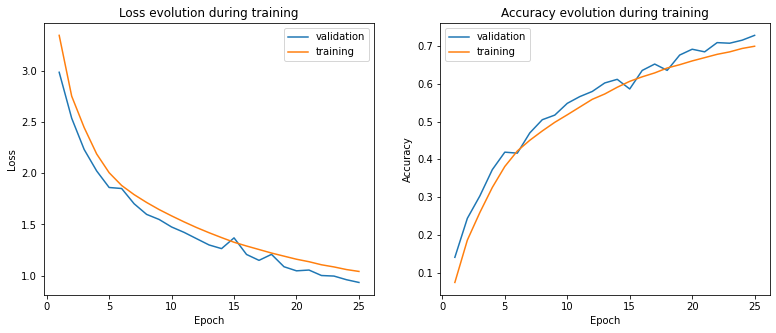

In [ ]:
lr = 1e-4 
batch_size = 16
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 25

all_curves = []
times = []

for train_run in range(n_trains):
    model_rnn_noisy = RNNModel(13)

    curves, total_time = train_model(
        model_rnn_noisy,
        train_dataset_noisy,
        val_dataset_noisy,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

Accuracy: 70.14%


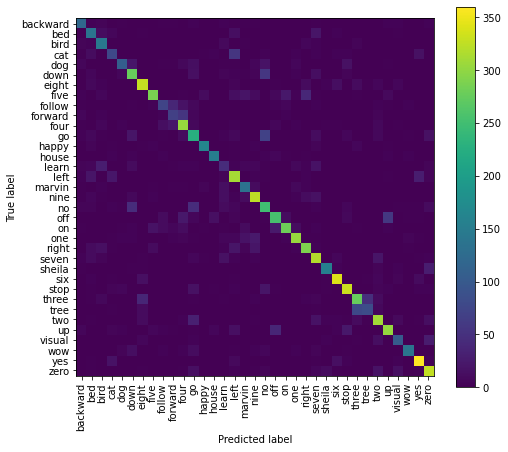

In [ ]:
get_metrics_and_confusion_matrix(model_rnn_noisy, test_dataset_noisy)

### entrenamiento GRU con ventanas de 512 y ruido

In [14]:
# Create training, validation and testing split of the data.

train_dataset_noisy_512 = Create_DataSet_Noisy("training", 512)
val_dataset_noisy_512 = Create_DataSet_Noisy("validation", 512)
test_dataset_noisy_512 = Create_DataSet_Noisy("testing", 512)

In [ ]:
lr = 1e-4 
batch_size = 16
criterion = nn.CrossEntropyLoss()
n_trains = 1
early_stopping_tolerance = 5

epochs = 15

all_curves = []
times = []

for train_run in range(n_trains):
    model_rnn_noisy_512 = RNNModel(13)

    curves, total_time = train_model(
        model_rnn_noisy_512,
        train_dataset_noisy_512,
        val_dataset_noisy_512,
        epochs,
        criterion,
        batch_size,
        lr,
        early_stopping_tolerance=early_stopping_tolerance,
        use_gpu=True,
    )

    all_curves.append(curves)
    times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(times):.2f} +- {np.std(times):.2f} [s]")

show_curves(all_curves)

Accuracy: 17.92%


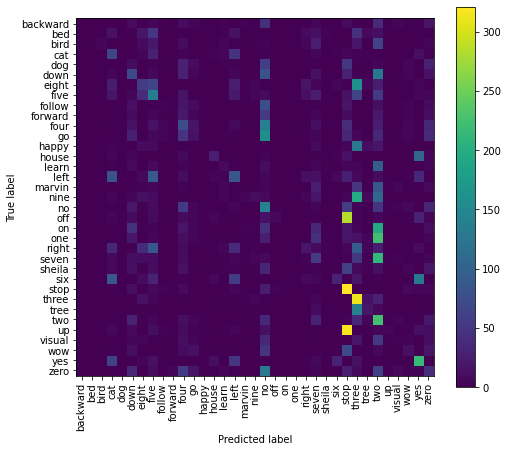

In [16]:
get_metrics_and_confusion_matrix(model_rnn_noisy_512, test_dataset_noisy_512)